In [39]:
import os
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.interpolate import make_interp_spline, BSpline

%matplotlib inline
sns.set(style="whitegrid")
FIGSIZE = [8, 5]

In [2]:
JH_DATASETS = ['confirmed', 'deaths', 'recovered']
def transform_johns_hopkins(df):
    df = df.groupby('Country/Region').sum()
    cols = list(df.columns)
    cols.remove('Lat')
    cols.remove('Long')
    df = df[cols]
    df = df.transpose()
    df.index = pd.to_datetime(df.index, format='%m/%d/%y')
    df.index.name = "Date"
    return df#[columns]

def get_johns_hopkins(kind='confirmed'):
    assert kind in JH_DATASETS
    url = f"https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_{kind}_global.csv"
    df = pd.read_csv(url)
    df = transform_johns_hopkins(df)
    fname = f"data/CSSEGUSandData/time_series_covid19_{kind}_global.csv"
    df.to_csv(fname)
    return df

In [3]:
SINAVE_DATASETS = ['confirmados', 'probables', 'muertos', 'descartados']
def transform_sinave_eduardofv(df):
    df = df.groupby('Estado').sum()
    df = df.transpose()
    df.index = pd.to_datetime(df.index, format='%Y/%m/%d')
    df.index.name = "Date"
    return df#[columns]

def get_sinave_eduardofv(kind="confirmados"):
    assert kind in SINAVE_DATASETS
    url = f"https://raw.githubusercontent.com/eduardofv/covid/master/data/sinave_agregados/series_tiempo/serie_tiempo_{kind}.csv"
    df = pd.read_csv(url)
    df = transform_sinave_eduardofv(df)
    return df    

In [4]:
def get_new_per_day(df):
    new_per_day = {}
    for location in df.columns:
        d = df[location]
        dif = [d[i] - d[i-1] for i in range(1,len(d))]
        new_per_day[location] = dif

    df_new_per_day = pd.DataFrame(new_per_day)
    df_new_per_day.index = df.index[1:]
    return df_new_per_day

In [5]:
def calculate_new_last_period(df_new_per_day, PERIOD=7):
    new_per_period = {}
    for location in df_new_per_day.columns:
        d = df_new_per_day[location]
        cum = [sum(d[(i-PERIOD):i]) for i in range(PERIOD, len(d))]
        new_per_period[location] = cum
    return new_per_period

In [6]:
def cum_and_new_from_init(cum, new, init=99):
    cum_from_init = cum[cum > init]
    new_from_init = new[-len(cum_from_init):]
    assert len(cum_from_init) == len(new_from_init)
    return cum_from_init, new_from_init

In [76]:
def get_values_from_first_geq(values, min_value):
    for index, value in enumerate(values):
        if value >= min_value:
            return values[index:]
    return []

def get_values_since(series, min_value, fill_to=None):
    series = get_values_from_first_geq(series, min_value)
    if fill_to is not None:
        series = pd.Series(list(series) + [0] * (fill_to - len(series)))
    return series.reset_index(drop=True)

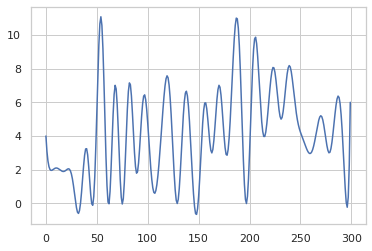

In [89]:
d = world['daily_deaths']['Korea, South']



d = get_values_from_first_geq(d, 3).reset_index(drop=True)



0       41
1       53
2       82
3       93
4      118
5      164
6      203
7      251
8      316
9      367
10     405
11     475
12     585
13     717
14     848
15     993
16    1094
17    1215
18    1378
19    1510
20    1688
21    1890
22    2143
23    2439
Name: Mexico, dtype: int64
0         51
1         51
2         57
3         58
4         60
5         68
6         74
7         98
8        118
9        149
10       217
11       262
12       402
13       518
14       583
15       959
16      1281
17      1663
18      2179
19      2727
20      3499
21      4632
22      6421
23      7783
24     13747
25     19273
26     25600
27     33276
28     43847
29     53740
30     65778
31     83836
32    101657
33    121478
34    140909
35    161837
36    188172
37    213372
38    243616
39    275586
40    308850
41    337072
42    366667
43    396223
Name: US, dtype: int64


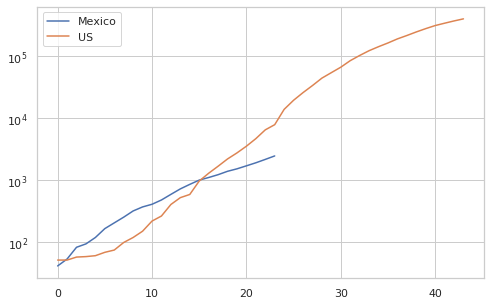

In [122]:
#Splines: https://stackoverflow.com/questions/5283649/plot-smooth-line-with-pyplot
def smooth_plot(data, num_points=300, k=3):
    xnew = np.linspace(d.index.min(), d.index.max(), num_points) 
    spl = make_interp_spline(d.index, d, k=k)  # type: BSpline
    power_smooth = spl(xnew)
    plt.plot(power_smooth)
    
def graph_daily_metric(df, 
                       locations, 
                       since=None,
                       min_y=0,
                       log=False, 
                       ylabel=None, 
                       smooth=False):
    f, ax = plt.subplots(figsize=FIGSIZE)
    if log:
        ax.set(yscale='log')
    for location in locations:
        d = df[location]
        if since is not None:
            d = get_values_since(d, since)
        d[d < min_y] = np.NaN
        print(d)
        if smooth:
            smooth_plot(d)
        else:
            sns.lineplot(x=d.index, y=d)
    ax.set(ylabel=ylabel)
    plt.legend(locations)

graph_daily_metric(dfw,
                   ['Mexico', 'US'],
                   #analysis_countries, 
                   since=30,
                   #smooth=True,
                   log=True)
plt.show()

# Mundo

In [35]:
analysis_countries = ["Mexico", "US", "Spain", "Italy", "China", "Korea, South"]
world = {}
for dset in JH_DATASETS:
    world[dset]= get_johns_hopkins(dset)
    world[f"daily_{dset}"] = get_new_per_day(world[dset])

world['daily_deaths'][analysis_countries].tail(10)

,Mexico,US,Spain,Italy,China,"Korea, South"
Date,,,,,,
2020-03-29,4,441,821,756,5,8
2020-03-30,4,511,913,812,4,6
2020-03-31,8,895,748,837,1,4
2020-04-01,1,884,923,727,7,3
2020-04-02,8,1169,961,760,6,4
2020-04-03,13,1161,850,766,4,5
2020-04-04,10,1320,749,681,4,3
2020-04-05,19,1212,694,525,3,6
2020-04-06,15,1164,700,636,2,3


In [130]:
sum(world['deaths']['Korea, South'])

3935

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
5      NaN
6     13.0
7     10.0
8     19.0
9     15.0
10    31.0
Name: Mexico, dtype: float64
0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
5        NaN
6        NaN
7        NaN
8        NaN
9        NaN
10       NaN
11       NaN
12       NaN
13       NaN
14      22.0
15      23.0
16      10.0
17      82.0
18      44.0
19      63.0
20     110.0
21     140.0
22     149.0
23     236.0
24     267.0
25     372.0
26     445.0
27     441.0
28     511.0
29     895.0
30     884.0
31    1169.0
32    1161.0
33    1320.0
34    1212.0
35    1164.0
36    1939.0
Name: US, dtype: float64
0       NaN
1       NaN
2      11.0
3       NaN
4      19.0
5       NaN
6      78.0
7      62.0
8      94.0
9      53.0
10    191.0
11     90.0
12    207.0
13    213.0
14    332.0
15    397.0
16    539.0
17    497.0
18    839.0
19    718.0
20    773.0
21    844.0
22    821.0
23    913.0
24    748.0
25    923.0
26    961.0
27    850.0
28    74

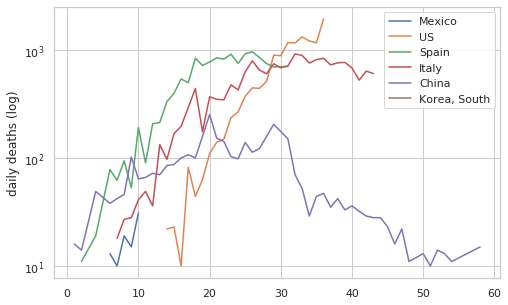

In [124]:
graph_daily_metric(world['daily_deaths'],
                   analysis_countries,
                   min_y = 10,
                   since=3,
                   ylabel='daily deaths (log)',
                   log=True)

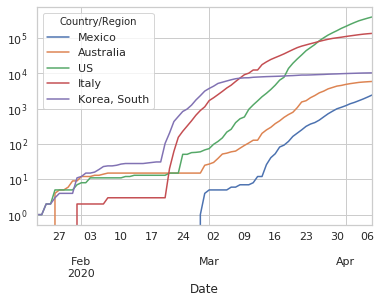

In [14]:
dfw[analysis_countries].plot(logy=True)

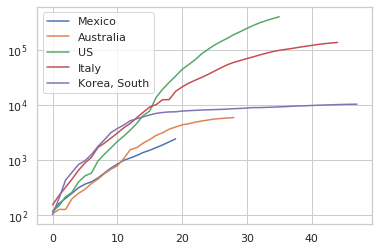

In [15]:
for country in analysis_countries:
    values_since = get_values_since(dfw[country], since_value=100)
    values_since.plot(logy=True)
plt.legend(analysis_countries)

In [16]:
dfw_new_per_day = get_new_per_day(dfw)
dfw_new_per_day[analysis_countries].tail()

,Mexico,Australia,US,Italy,"Korea, South"
Date,,,,,
2020-04-03,132,214,31970,4585,86
2020-04-04,178,220,33264,4805,94
2020-04-05,202,137,28222,4316,81
2020-04-06,253,110,29595,3599,47
2020-04-07,296,98,29556,3039,47


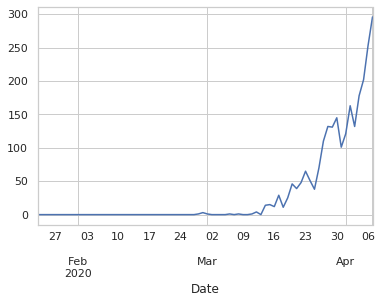

In [17]:
dfw_new_per_day['Mexico'].plot()

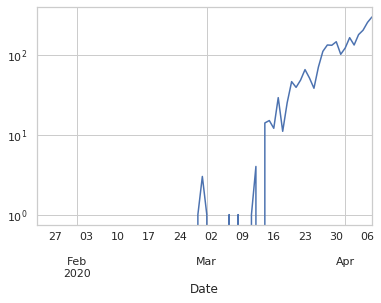

In [18]:
dfw_new_per_day['Mexico'].plot(logy=True)

Text(0, 0.5, 'new cases per day')

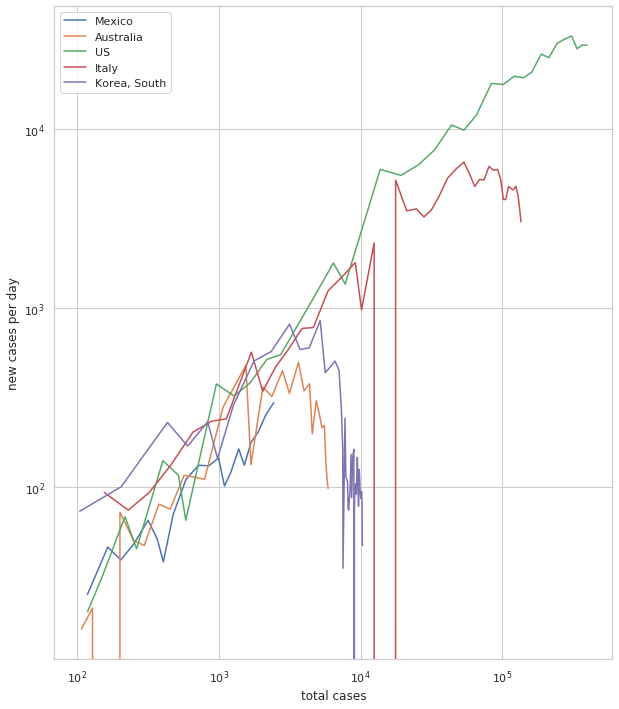

In [19]:
#Genius Eric & Aatish: https://aatishb.com/covidtrends/
f, ax = plt.subplots(figsize=[10,12])
ax.set(yscale="log", xscale="log")
for country in analysis_countries:
    cum, new = cum_and_new_from_init(dfw[country], 
                                     dfw_new_per_day[country], 
                                     init=100)
    plt.plot(cum, new)
plt.legend(analysis_countries)
plt.xlabel("total cases")
plt.ylabel("new cases per day")

Text(0, 0.5, 'new cases last days')

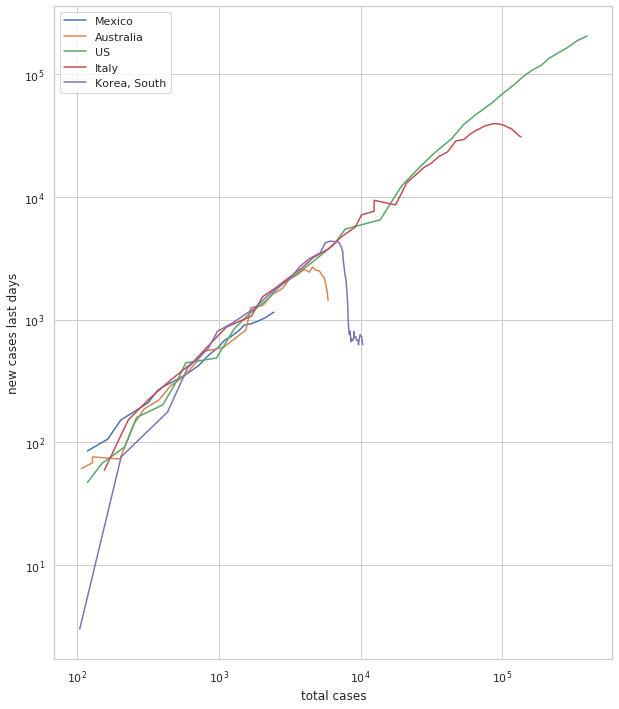

In [20]:
new_last_period = calculate_new_last_period(dfw_new_per_day, PERIOD=7)

#Genius Eric & Aatish: https://aatishb.com/covidtrends/
f, ax = plt.subplots(figsize=[10,12])
ax.set(yscale="log", xscale="log")
for country in analysis_countries:
    cum, new = cum_and_new_from_init(dfw[country], 
                                     new_last_period[country], 
                                     init=100)
    plt.plot(cum, new)
plt.legend(analysis_countries)
plt.xlabel("total cases")
plt.ylabel("new cases last days")

# México

In [21]:
estados = ["Ciudad de México", "Nuevo León", "Jalisco", "Queretaro"]

dfmx = get_sinave_eduardofv('confirmados')
dfmx_descartados = get_sinave_eduardofv('descartados')
dfmx_probables = get_sinave_eduardofv('probables')
dfmx[estados].tail(10)

Estado,Ciudad de México,Nuevo León,Jalisco,Queretaro
Date,,,,
2020-03-30,205,75,90,27
2020-03-31,234,76,94,29
2020-04-01,296,78,99,29
2020-04-02,327,84,104,32
2020-04-03,384,85,116,35
2020-04-04,469,88,120,36
2020-04-05,560,91,123,38
2020-04-06,609,93,126,40
2020-04-07,723,93,135,45


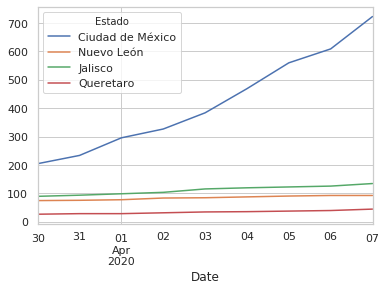

In [22]:
dfmx[estados].plot(logy=False)

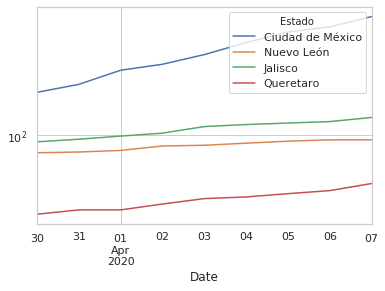

In [23]:
dfmx[estados].plot(logy=True)

In [24]:
total_mx = dfmx.sum(axis=1)
total_mx[-10:]

Date
2020-03-30    1094
2020-03-31    1215
2020-04-01    1378
2020-04-02    1510
2020-04-03    1688
2020-04-04    1890
2020-04-05    2143
2020-04-06    2439
2020-04-07    2785
dtype: int64

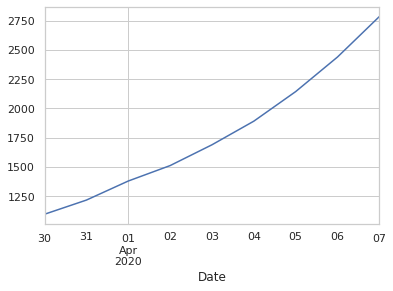

In [25]:
total_mx.plot()

In [26]:
dfmx_new_per_day = get_new_per_day(dfmx)
dfmx_new_per_day[estados].tail()

,Ciudad de México,Nuevo León,Jalisco,Queretaro
Date,,,,
2020-04-03,57,1,12,3
2020-04-04,85,3,4,1
2020-04-05,91,3,3,2
2020-04-06,49,2,3,2
2020-04-07,114,0,9,5


In [27]:
total_new = dfmx_new_per_day.sum(axis=1)
total_new[-10:]

Date
2020-03-31    121
2020-04-01    163
2020-04-02    132
2020-04-03    178
2020-04-04    202
2020-04-05    253
2020-04-06    296
2020-04-07    346
dtype: int64

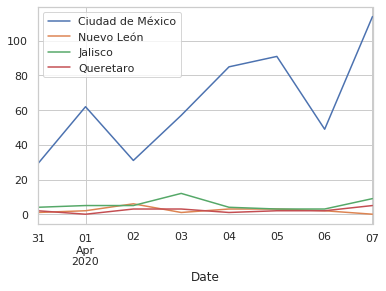

In [28]:
for estado in estados:
    dfmx_new_per_day[estado].plot()
plt.legend(estados)

In [29]:
total_probables = dfmx_probables.sum(axis=1)
total_descartados = dfmx_descartados.sum(axis=1)
total_pruebas = total_mx + total_probables + total_descartados
prop_confirmados = total_mx / total_pruebas
prop_confirmados[-10:]

Date
2020-03-30    0.115389
2020-03-31    0.110374
2020-04-01    0.112233
2020-04-02    0.107973
2020-04-03    0.107612
2020-04-04    0.109986
2020-04-05    0.118831
2020-04-06    0.119121
2020-04-07    0.109603
dtype: float64

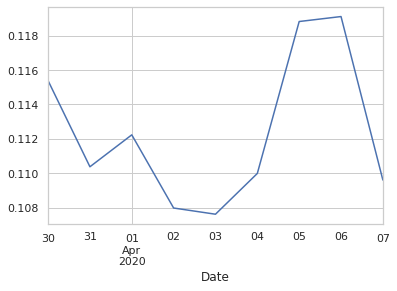

In [30]:
prop_confirmados.plot()